In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# What do the demographics looks like for the training set?

In [2]:
# read data
demo_data = pd.read_csv('gender_age_train.csv')
demo_data.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


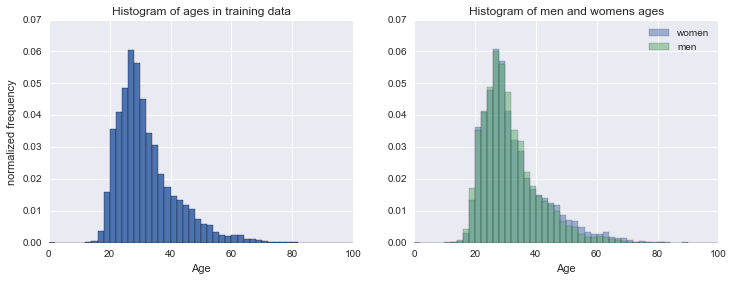

In [3]:
# plot data
age = np.array(demo_data['age'])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.hist(age, range=[0,100], bins=50, normed=True)
plt.xlabel('Age')
plt.ylabel('normalized frequency')
plt.title('Histogram of ages in training data')

# now plot separately for men and women
women_age = age[np.where(demo_data['gender'] == 'F')]
men_age = age[np.where(demo_data['gender'] == 'M')]
plt.subplot(1,2,2)
plt.hist(women_age, range=[0,100], bins=50, normed=True, alpha=0.5, label='women')
plt.hist(men_age, range=[0,100], bins=50, normed=True, alpha=0.5, label='men')
plt.legend()
plt.xlabel('Age')
plt.title('Histogram of men and womens ages')

Men and women are similar in age. Women tend to be a bit older. It looks like there are some zero ages. This is probably missing data. 

# Phone brand and model

In [4]:
# read data
phone_data = pd.read_csv('phone_brand_device_model.csv')
phone_data.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


Unfortunately, phone brands are in Chinese. Replace names based on translation on Kaggle.

In [5]:
# replace chinese phone brands with english names
chinese_brands = ['三星','天语', '海信', '联想', '欧比', '爱派尔', '努比亚', '优米', '朵唯', '黑米', '锤子', '酷比魔方', '美图',
                 '尼比鲁', '一加', '优购', '诺基亚', '糖葫芦', '中国移动', '语信', '基伍', '青橙', '华硕', '夏新', '维图', 
                  '艾优尼', '摩托罗拉', '乡米', '米奇', '大可乐', '沃普丰', '神舟','摩乐', '飞秒', '米歌', '富可视', '德赛',
                  '梦米', '乐视', '小杨树', '纽曼', '邦华', 'E派', '易派', '普耐尔', '欧新', '西米', '海尔', '波导', '糯米', 
                  '唯米', '酷珀', '谷歌', '昂达', '聆韵', '小米']
english_brands = ['samsung', 'Ktouch', 'hisense', 'lenovo', 'obi', 'ipair', 'nubia', 'youmi', 'dowe', 'heymi', 
                  'hammer', 'koobee', 'meitu', 'nibilu', 'oneplus', 'yougo', 'nokia', 'candy', 'ccmc', 'yuxin', 
                  'kiwu', 'greeno', 'asus', 'panasonic', 'weitu', 'aiyouni', 'motorola', 'xiangmi', 'micky', 
                  'bigcola', 'wpf', 'hasse', 'mole', 'fs', 'mige', 'fks', 'desci', 'mengmi', 'Ishi', 'smallt',
                  'newman', 'banghua', 'epai', 'epai', 'pner', 'ouxin', 'ximi', 'haier', 'bodao', 'nuomi', 'weimi', 
                  'kupo', 'google', 'ada', 'lingyun', 'xiaomi']

if (len(chinese_brands) != len(english_brands)):
    print('ERROR, band names do not match')

for i in range(0, len(chinese_brands)):
    phone_data.loc[phone_data['phone_brand'] == chinese_brands[i], 'phone_brand'] = english_brands[i]
    
phone_data.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,xiaomi,红米
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,samsung,Galaxy Note 2


In [6]:
# let's take a look at if there are more phone brands not labelled
len(phone_data.groupby('phone_brand').size())

# add additional column for phone brand integer
phone_data['phone_brand_index'] = 0

phone_data_unique = phone_data.groupby('phone_brand').first()
brands = phone_data_unique.index.unique()

# doesn't need own category if less than 600 users
minor_brands = np.where(phone_data.groupby('phone_brand').size() < 600)
ind = 1
for i in range(0, len(brands)):
    if i in minor_brands[0]:
        phone_data.loc[phone_data['phone_brand'] == brands[i], 'phone_brand_index'] = 0
    else:
        phone_data.loc[phone_data['phone_brand'] == brands[i], 'phone_brand_index'] = ind
        ind += 1

print(ind)
phone_data.head()

17


,device_id,phone_brand,device_model,phone_brand_index
0,-8890648629457979026,xiaomi,红米,10
1,1277779817574759137,xiaomi,MI 2,10
2,5137427614288105724,samsung,Galaxy S4,8
3,3669464369358936369,SUGAR,时尚手机,0
4,-5019277647504317457,samsung,Galaxy Note 2,8


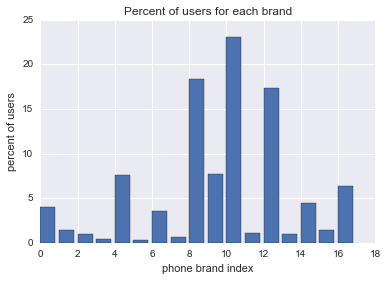

In [7]:
plt.bar(range(0,ind), phone_data.groupby('phone_brand_index').size()/ (phone_data.count()[0].astype('float') + 1) * 100)
plt.xlabel('phone brand index')
plt.ylabel('percent of users')
plt.title('Percent of users for each brand')

We see that although there are many brands, a few brands dominate. The most popular, 13, corresponds to xiaomi, which I know to be a popular brand in China. Samsung is the next popular brand. 

Next, we investigate if there is a difference in popularity between men and women for phone brands.

In [8]:
# merge data frames
all_data = pd.merge(demo_data, phone_data, on='device_id')
all_data.head()

,device_id,gender,age,group,phone_brand,device_model,phone_brand_index
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,10
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,10
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,10
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,10
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,10


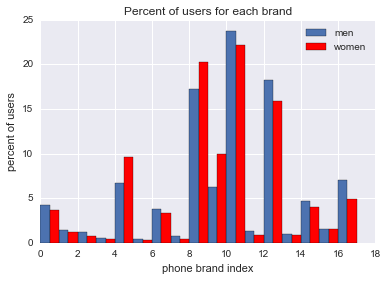

In [9]:
men = all_data[all_data['gender'] == 'M']
women = all_data[all_data['gender'] == 'F']

plt.bar(range(0,ind), 
        men.groupby('phone_brand_index').size()/ (men.count()[0].astype('float') + 1) * 100, 
        width=0.5, label='men')
plt.bar(np.arange(0,ind)+0.5, 
        women.groupby('phone_brand_index').size()/ (women.count()[0].astype('float') + 1) * 100, 
        width=0.5, color='red', label='women')
plt.xlabel('phone brand index')
plt.ylabel('percent of users')
plt.title('Percent of users for each brand')
plt.legend()

We see some differences in preferences between men and women: OPPO brand is preferred by women, as is Samsung and vivo, while Xiaomi, Huawei are is preferred by men. Interestingly, a quick Google search reveals that OPPO is an iphone copy.

(0, 18)

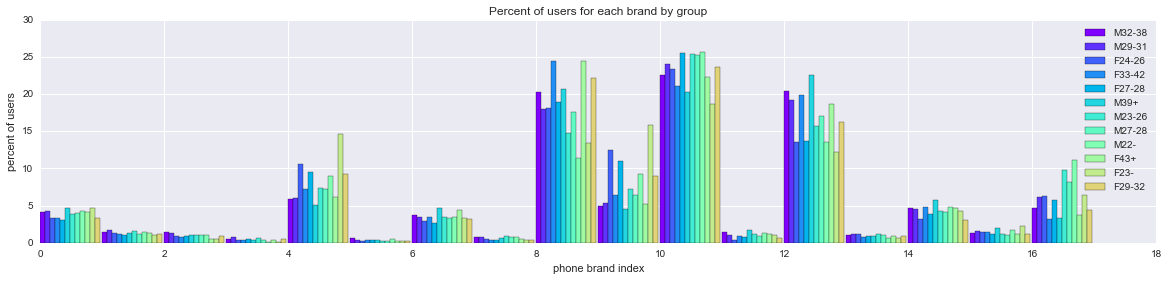

In [10]:
# what about age?
groups = all_data['group'].unique()
plt.figure(figsize=(20,4))

offset = 0
colors = plt.cm.rainbow(np.linspace(0,1,ind))

for group, color in zip(groups, colors):
    group_data = all_data[all_data['group'] == group]
    plt.bar(np.arange(0,ind)+offset, 
        group_data.groupby('phone_brand_index').size()/ (group_data.count()[0].astype('float') + 1) * 100, 
        width=0.08, label=group, color=color)
    offset += 0.08

plt.xlabel('phone brand index')
plt.ylabel('percent of users')
plt.title('Percent of users for each brand by group')
plt.legend()
plt.xlim(0,ind+1)

Not the best visualization, but we see that LG (4) is especially popular among young women, while Samsung (8) is unpopular with both young men and women, but more popular with an older crowd. Vivo is also popular among young people, while Xiaomi is popular all around. 

In [11]:
all_data.groupby('phone_brand_index').first()

,device_id,gender,age,group,phone_brand,device_model
phone_brand_index,,,,,,
0,-7605360767281960867,M,48,M39+,aiyouni,U3
1,-1173303210238773591,F,34,F33-42,HTC,Butterfly
2,4465006065399441590,M,20,M22-,Ishi,超级手机1s
3,-2489556190686427591,M,35,M32-38,LG,Nexus 5
4,-1297074871525174196,F,24,F24-26,OPPO,R1C
5,4977791024608210667,M,31,M29-31,ccmc,M601
6,-4370696809239943432,M,36,M32-38,lenovo,Vibe Z2 Pro
7,-1279883160764317574,M,31,M29-31,nubia,Z5S Mini
8,1596610250680140042,F,36,F33-42,samsung,Galaxy S4


# Events

In [12]:
# read data
event_data = pd.read_csv("events.csv") #, dtype={'device_id': np.str})
event_data.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


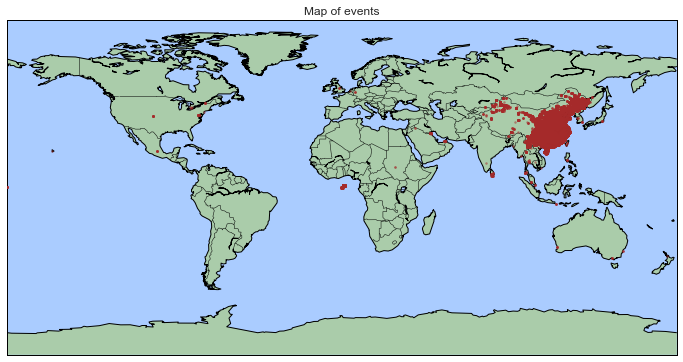

In [13]:
# too many data points to plot on map, so we need to first subsample data
event_data_sample = event_data.sample(n=300000)
plt.figure(1, figsize=(12,6))

# define colors
water_color='#AACCFF'
land_color='#AACCAA'

# make map
m = Basemap(projection='cyl', resolution='c')

m.drawcoastlines()
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawcountries()
m.drawmapboundary(fill_color=water_color)

# plot data
lat = event_data_sample['longitude'].tolist()
lon = event_data_sample['latitude'].tolist()
m.scatter(lat, lon, color='brown', alpha=0.5, zorder=5, s=4)

plt.title("Map of events")
plt.show()

Most of the data is in China, as we would expect. However, there are some points at (0,0) that is probably not real. Are there differences in location between men and women? 

In [14]:
# merge data frames
merged_data = pd.merge(demo_data, event_data, on='device_id', how='inner')
merged_data.head()

,device_id,gender,age,group,event_id,timestamp,longitude,latitude
0,-8260683887967679142,M,35,M32-38,2479656,2016-05-01 14:23:37,0.00,0.00
1,7477216237379271436,F,37,F33-42,280934,2016-05-04 14:10:03,119.57,31.75
2,7477216237379271436,F,37,F33-42,363585,2016-05-04 14:13:30,119.57,31.75
3,7477216237379271436,F,37,F33-42,935225,2016-05-06 18:51:15,0.00,0.00
4,7477216237379271436,F,37,F33-42,1551108,2016-05-04 14:09:29,119.57,31.75


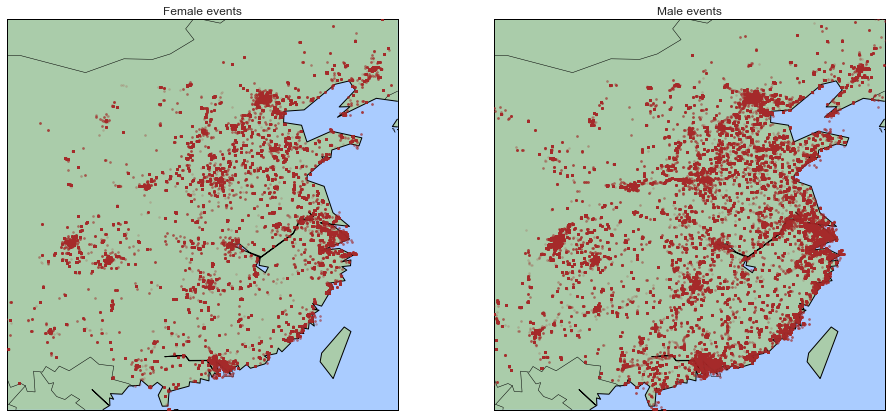

In [15]:
# plot male and female data separately, and zoom in
plt.figure(figsize=(16,7))

women = merged_data[merged_data['gender'] == 'F']
men = merged_data[merged_data['gender'] == 'M']

plt.subplot(1,2,1)
mw = Basemap(projection='cyl', resolution='c', urcrnrlon=125, urcrnrlat=45, llcrnrlat=20, llcrnrlon=100)

mw.drawcoastlines()
mw.fillcontinents(color=land_color, lake_color=water_color)
mw.drawcountries()
mw.drawmapboundary(fill_color=water_color)

# plot data
lat = np.array(women['longitude'])
lon = np.array(women['latitude'])
mw.scatter(lat, lon, color='brown', alpha=0.2, zorder=5, s=4)

plt.title("Female events")

plt.subplot(1,2,2)
mm = Basemap(projection='cyl', resolution='c', urcrnrlon=125, urcrnrlat=45, llcrnrlat=20, llcrnrlon=100)

mm.drawcoastlines()
mm.fillcontinents(color=land_color, lake_color=water_color)
mm.drawcountries()
mm.drawmapboundary(fill_color=water_color)

# plot data
lat = np.array(men['longitude'])
lon = np.array(men['latitude'])
mm.scatter(lat, lon, color='brown', alpha=0.2, zorder=5, s=4)

plt.title("Male events")

Male events tend to be more spread out geographically, while female events are more concentrated in metropolitan areas. 

# App events

In [16]:
# read data
app_events = pd.read_csv("app_events.csv")
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [17]:
# read app labels
app_labels = pd.read_csv('app_labels.csv')
app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [18]:
# read label categories
label_data = pd.read_csv('label_categories.csv')
label_data.head()

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


In [19]:
# merge data frames
app_data = pd.merge(app_labels, label_data, on='label_id')
app_data.head()

,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,8756705988821000489,251,Finance
3,1061207043315821111,251,Finance
4,-1491198667294647703,251,Finance


In [20]:
app_data['category'].value_counts()

Industry tag                 56902
Custom label                 53936
Tencent                      49320
game                         48707
Property Industry 2.0        45697
1 free                       19083
Services 1                   11840
Property Industry new         9955
Relatives 1                   9027
Irritation / Fun 1            8831
Cards RPG                     7375
Casual puzzle categories      7052
Personal Effectiveness 1      5910
ARPG                          5306
Chess categories              5135
The elimination of class      5124
And the Church                4619
round                         3608
unknown                       2754
free                          2744
Personal Effectiveness        2588
Parkour avoid class           2496
Low liquidity                 2471
Shootout Shooting (STG)       2353
SLG (strategy)                2327
Property Industry 1.0         2243
Finance                       2208
Racing (RAC)                  2162
High risk           

I don't really understand these labels. 'The elimination of class'? Let's see if we can come up with better labels. 

In [21]:
# convert to lower case
label_data['category'] = label_data['category'].str.lower();

In [365]:
label_data['lumped_category'] = ''

# lets group all games together
for category in label_data['category']:
    if category != category:
        continue
    else:
        if ('game' in category or 'chess' in category or 'rpg' in category or 'warcraft' in category or
            'shooting' in category or 'racing' in category or 'tower defense' in category or 
            'mmo' in category or 'puzz' in category or 'dota' in category or 'majiang' in category or
            'poker' in category or 'gaming' in category or 'farm' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'games'
        elif ('bank' in category or 'financ' in category or 'wealth' in category or 
              'stock' in category or 'trust fund' in category or 'brokerage' in category or
              'futures' in category or 'securities' in category or 'trust' in category or 
              'shares' in category or 'income' in category or 'insurance' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'finance'
        elif ('health' in category or 'vitality' in category or 'pharmacy' in category or
              'doctor' in category or 'exercise' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'health'
        elif 'music' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'music'
        elif ('travel' in category or 'hotel' in category or 'tour' in category or
            'airline' in category or 'airport' in category or 'singapore' in category or 
            'united ' in category or 'australia' in category or 'austria' in category or
             'coach reservation' in category or 'rail' in category or 'taxi' in category or 'bus' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'travel'
        elif ('shopping' in category or 'stores' in category or 'bag' in category or 
              'online malls' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'shopping'
        elif ('education' in category or 'academic' in category or 'university' in category or
              'training' in category or 'math' in category or 'science' in category or 'study' in category or
              'foreign language' in category or 'professional skills' in category or 'student' in category or
              'school' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'education'
        elif ('weibo' in category or 'community' in category or 'social' in category or
              'blog' in category or 'im' in category or 'sharing' in category or 'mesasge' in category or
              'communitation' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'social networking'
        elif ('beauty' in category or 'makeup' in category or 'cosmetic' in category or 
              'fashion' in category or 'underwear' in category or 'cloth' in category or
              'nail' in category or 'shoe' in category or 'make-up' in category or 'skin' in category or
              'style' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'beauty and fashion'
        elif ('sport' in category or 'tennis' in category or 'basketball' in category or 'soccer' in category or
              'football' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'sports'
        elif 'science' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'science'
        elif ('utilit' in category or 'wifi' in category or 'app store' in category or 'browser' in category or 
              'email' in category or 'phone' in category or 'hardware' in category or 'clock' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'utility'
        elif ('video' in category or 'tv' in category or 'shows' in category or 'movie' in category or
              'entertainment' in category or 'comic' in category or 'joke' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'entertainment'
        elif ('food' in category or 'coffee' in category or 'dinner' in category or 'eat' in category or
              'recipe' in category or 'buffet' in category or 'dessert' in category or 'snack' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'food'
        elif 'art' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'arts'
        elif 'productiv' in category or 'work' in category or 'personal effectiveness' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'productivity'
        elif 'gambl' in category or 'lottery' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'gambling'
        elif 'dating' in category or 'romance' in category or 'love' in category or 'marr' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'dating'
        elif ('parent' in category or 'baby' in category or 'pregnancy' in category or 
              'maternal' in category or 'child' in category or 'babies' in category or 'fetus' in category or
              'kid' in category):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'parenting'
        elif 'property industry' in category or 'real estate' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'property industry'
        elif 'fun' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'fun'
        elif 'service' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'services'
        elif 'news' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'news'
        elif 'aviation' in category or 'magic' in category:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'hobby'
        elif (category == 'tencent' or category == 'industry tag' or category == 'custom label' or
              category == 'realtives 1' or category == '1 free'):
            label_data.loc[label_data['category'] == category, 'lumped_category'] = category
        else:
            label_data.loc[label_data['category'] == category, 'lumped_category'] = 'other'
        
label_data.head()

,label_id,category,lumped_category
0,1,NaN,
1,2,game-game type,games
2,3,game-game themes,games
3,4,game-art style,games
4,5,game-leisure time,games


In [366]:
label_data['lumped_category'].value_counts()

other                 414
games                 122
finance                57
travel                 56
beauty and fashion     30
social networking      29
education              29
entertainment          23
parenting              23
food                   17
utility                16
health                 15
shopping               15
fun                    14
sports                 12
services               10
arts                    9
music                   6
hobby                   6
productivity            5
property industry       5
dating                  4
gambling                4
                        3
news                    2
tencent                 1
industry tag            1
1 free                  1
custom label            1
Name: lumped_category, dtype: int64

In [367]:
label_data.groupby('lumped_category').size()

lumped_category
                        3
1 free                  1
arts                    9
beauty and fashion     30
custom label            1
dating                  4
education              29
entertainment          23
finance                57
food                   17
fun                    14
gambling                4
games                 122
health                 15
hobby                   6
industry tag            1
music                   6
news                    2
other                 414
parenting              23
productivity            5
property industry       5
services               10
shopping               15
social networking      29
sports                 12
tencent                 1
travel                 56
utility                16
dtype: int64

In [368]:
# merge data frames
app_data = pd.merge(app_labels, label_data, on='label_id')
app_data.head()

,app_id,label_id,category,lumped_category
0,7324884708820027918,251,finance,finance
1,-4494216993218550286,251,finance,finance
2,8756705988821000489,251,finance,finance
3,1061207043315821111,251,finance,finance
4,-1491198667294647703,251,finance,finance


In [369]:
app_data['lumped_category'].value_counts()

games                 93369
other                 61409
property industry     57895
industry tag          56902
custom label          53936
tencent               49320
1 free                19083
services              13556
finance               12765
social networking      9109
fun                    9047
productivity           8523
travel                 3634
beauty and fashion     1759
entertainment          1474
education              1455
shopping               1353
sports                 1132
parenting               950
music                   904
health                  823
gambling                542
arts                    336
hobby                   206
news                    184
dating                  152
utility                  68
food                     57
Name: lumped_category, dtype: int64

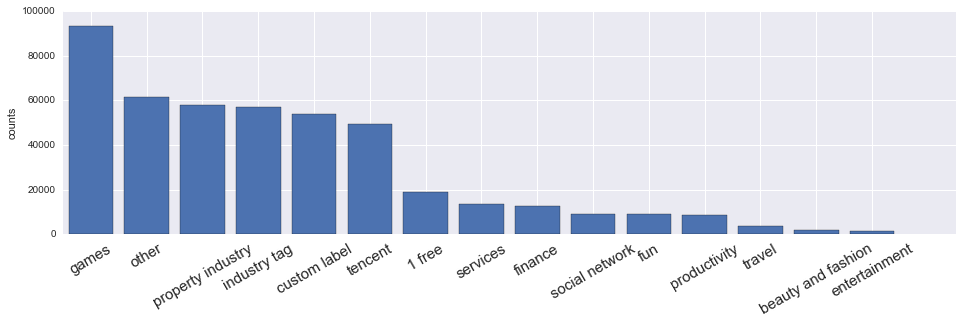

In [395]:
plt.figure(figsize=(16, 4))
plt.bar(np.arange(0,15), app_data['lumped_category'].value_counts()[0:15], align='center')
plt.xticks(np.arange(0,15), ['games', 'other', 'property industry', 'industry tag', 'custom label', 'tencent', 
                             '1 free', 'services', 'finance', 'social network', 'fun', 'productivity', 'travel', 
                             'beauty and fashion', 'entertainment'], rotation=30, fontsize=15)
plt.xlim([-0.5,15.5])
plt.ylabel('counts')

We can definitely still group the apps better, as the "other" category is still too large. I'll leave this as-is for now and come back to it. 

In [401]:
# men vs. women
app_demo_data = pd.merge(app_events, app_data, on='app_id')
app_demo_data.tail()

,event_id,app_id,is_installed,is_active,label_id,category,lumped_category
209355705,3250591,-3613993005628921961,1,1,874,comfortable,other
209355706,3250591,-3613993005628921961,1,1,854,property industry new,property industry
209355707,3251334,7499801479003898729,1,0,548,industry tag,industry tag
209355708,3251334,7499801479003898729,1,0,859,pursue,other
209355709,3251334,7499801479003898729,1,0,854,property industry new,property industry


In [402]:
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


Is each event associated with multiple apps? I am confused...